# Solve the simple pendulum problem with DAEs solvers

## Mathematical modelling



One can use the Euler-Lagrange equation:
$$\frac{d}{dt}\left( \frac{\partial}{\partial \dot{\mathbf{q}}} \mathcal{L}(\mathbf{q}, \dot{\mathbf{q}}) \right) = \frac{\partial}{\partial \mathbf{q}} \mathcal{L}(\mathbf{q}, \dot{\mathbf{q}})$$

with:
    $$\mathcal{L}(\mathbf{q}, \dot{\mathbf{q}}) = T - U - \lambda C$$
    such that:
- $T = \frac{m}{2} (\dot{x}^2 + \dot{y}^2)$ (kinetic energy) 
- $U = mgy$ (potential energy)
- $C = 0.5 (x^2 + y^2 - L^2)$ (constraint)
- $(x,y)$ are the coordinates of the mass at the end of the pendulum
- $L$ is the length of the pendulum and $m$ the mass of the pendulum

Then apply the Euler-Lagrange equation to mecanical constrained systems:

$$\frac{d}{dt}\left( \frac{\partial}{\partial \dot{\mathbf{q}}} T(\mathbf{q}, \dot{\mathbf{q}}) \right) = \frac{\partial}{\partial \mathbf{q}} T(\mathbf{q}, \dot{\mathbf{q}}) + f(t, \mathbf{q},\dot{\mathbf{q}}) + \mathbf{G}^T \lambda$$
$$0 = \phi(\mathbf{q})$$

such that

- $\mathbf{q}$ is the vector of state variables
- $f$ are the external forces (here: the weight)
- $\phi(\mathbf{q})$ is the contraint such that $\mathbf{G} = d\phi(\mathbf{q})/dq$

Applying this Euler-Equation to our pendulum gives us:

\begin{align*}
\left\{
\begin{aligned}
\dot{x} &= u \\
\dot{y} &= v \\
\dot{u} &= \lambda x \\
\dot{v} &= \lambda y - g \\
0 &= x^2 + y^2 - L^2
\end{aligned}\right.
\end{align*}

This is an index 3 DAE system since 3 successive derivations of the constraint(s) must be applied to obtain an ODE. Thus, deriving twice the constraint gives us the following index 1 DAE system:

\begin{align*}
\left\{
\begin{aligned}
\dot{x} &= u \\
\dot{y} &= v \\
\dot{u} &= \lambda x \\
\dot{v} &= \lambda y - g \\
L^2 \lambda &= gy - u^2 - v^2
\end{aligned}\right.
\end{align*}

The ODE system can be simplified using angular coordinates such that $x = L \, sin(\theta)$ and $y= -L \, cos(\theta)$:
\begin{align*}
\left\{
\begin{aligned}
\dot{\theta} &= \omega\\
\dot{\omega} &= - \frac{g}{L} sin(\theta)
\end{aligned}\right.
\end{align*}

## Solving those systems with DAEs solvers

In [1]:
# import solvers
from solvers.bdfSolver import BDFModified
from solvers.sabm import SABM
from solvers.radau import RadauModified
from solvers.rosScipyFinal import Rosenbrock

In [2]:
# import other useful modules
from time import time
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
import numpy as np

Declare the constants of the pendulum problem:

In [3]:
L = 1
g = 9.81
m = 1
Tend = 2*np.pi*np.sqrt(L/g)
tspan = [0, Tend]
y0 = [1, 0, 0, 0, 0]

Create the function describing the DAEs systems such that $M \dot{y} = f(t,y)$:

In [4]:
# index 3 DAE system, right hand side (rhs) function
def f_pendule_index3(t, y):
    # y = x, y, u, v, l
    res = np.zeros(5)
    res[0] = y[2]
    res[1] = y[3]
    res[2] = y[4]*y[0]
    res[3] = y[4]*y[1] - g
    res[4] = y[0]**2 + y[1]**2 - L**2
    return res


# index 1 DAE system, rhs function
def f_pendule_index1(t, X):
    x = X[0]
    y = X[1]
    vx = X[2]
    vy = X[3]
    lbda = X[4]
    return np.array([vx, vy, -x*lbda/m, -g-(y*lbda)/m, lbda*(x**2+y**2)/m + g*y - (vx**2 + vy**2)])

# mass matrix
M = np.eye(5)
M[-1, -1] = 0

# functions of the rhs linked to the derivatives, it's the rhs of the ODE part of the DAE system
def fun(t, y, x):
    X = y[0]
    Y = y[1]
    vx = y[2]
    vy = y[3]
    lbda = x[0]
    return np.array([vx, vy, -X*lbda/m, -g-(Y*lbda)/m])

# algebraic constraints
def gun(t, y, x):
    X = y[0]
    Y = y[1]
    vx = y[2]
    vy = y[3]
    lbda = x[0]
    return np.array([lbda*(X**2+Y**2)/m + g*Y - (vx**2 + vy**2)])

Parameters of the DAEs solvers similar to those scipy solve_ivp:

In [5]:
kwargsBDF = {
    'fun': f_pendule_index1,
    't_span': tspan,
    'y0': y0,
    'mass': M,
    'method': BDFModified,
    'rtol': 1e-3,
    'atol': 1e-3
}


kwargsRadau = {
    'fun': f_pendule_index3,
    't_span': tspan,
    'y0': y0,
    'mass': M,
    'method': RadauModified,
    'rtol': 1e-3,
    'atol': 1e-3,
    'max_step': tspan[-1]/10,
    'first_step': 1e-3,
    'dense_output': False
}

kwargsSABM = {
    'fun': fun,
    't_span': tspan,
    'y0': y0,
    'method': SABM,
    'gun': gun,
    'num_diff': 4,
    'order': 2,
    'atol': 1e-3,
    'rtol': 1e-3,
    'mode': 'Explicit'
}

Solve the DAEs:

In [6]:
kwargs = kwargsSABM
before = time()
sol = solve_ivp(**kwargs)
print(f'Success: {sol.success}')
print(f'Temps de calcul : {time()-before}')
t = sol.t

x = sol.y[0,:]
y = sol.y[1,:]

Success: True
Temps de calcul : 0.05983853340148926


Solve the ODEs for the reference solution:

In [7]:
def solve_ODE():
    def ode(t, y):
        theta = y[0]
        dtheta = y[1]
        return np.array([dtheta,
                        -g/L*np.sin(theta)])

    y0 = np.array([np.pi/2, 0])
    sol_ODE = solve_ivp(fun=ode, t_span=[tspan[0], sol.t[-1]], y0=y0, rtol=1e-12,
                        atol=1e-12, max_step=tspan[-1]/10, method='DOP853', t_eval=sol.t)
    theta = sol_ODE.y[0, :]
    x_ODE = L*np.sin(theta)
    y_ODE = -L*np.cos(theta)
    return sol_ODE.t, x_ODE, y_ODE


t_ODE, x_ODE, y_ODE = solve_ODE()

Plot the $x$ and $y$ coordinates

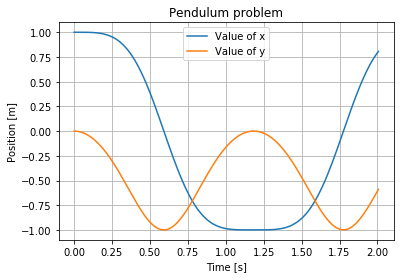

In [8]:
plt.figure()
plt.plot(t, x, label="Value of x")
plt.plot(t, y, label="Value of y")
plt.title("Pendulum problem")
plt.xlabel("Time [s]")
plt.ylabel("Position [m]")
plt.grid()
plt.legend()
plt.show()

Plot of the error in comparaison with the ODE solution:

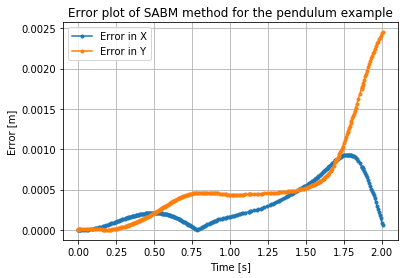

In [9]:
plt.figure()
plt.plot(sol.t, abs(x - x_ODE),".-", label='Error in X')
plt.plot(sol.t, abs(y - y_ODE),".-", label='Error in Y')
plt.title(
    f'Error plot of {kwargs["method"].__name__} method for the pendulum example')
plt.xlabel('Time [s]')
plt.ylabel('Error [m]')
plt.grid()
plt.legend()
plt.show()

## Remarks

One can observe that the RadauIIa method is able to solve the index 3 DAEs system whereas the BDF and SEABM are restricted to index 1 DAEs system. Note that RadauIIa achieves a high degree of accuracy since the error is of order $10^{-5}$ for a tolerance of $10^{-3}$.